<a href="https://colab.research.google.com/github/gskumlehn/maltese-or-poodle/blob/main/mobilenet_pug_or_whippet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Updates database from github repository

In [1]:
!rm -rf maltese-or-poodle
!git clone https://github.com/gskumlehn/maltese-or-poodle.git

Cloning into 'maltese-or-poodle'...
remote: Enumerating objects: 1011, done.
remote: Counting objects: 100% (1011/1011), done.
remote: Compressing objects: 100% (1007/1007), done.
remote: Total 1011 (delta 25), reused 970 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (1011/1011), 32.24 MiB | 11.48 MiB/s, done.
Resolving deltas: 100% (25/25), done.


Creates two MobileNet models that share the same architecture and pre-trained weights but operate on different input layers:

model: Processes raw/original input data.

augmented_data_model: Processes augmented versions of the input data.

In [2]:
import keras
from keras.applications import MobileNet

model=MobileNet(weights='imagenet', include_top=False)
augmented_data_model=MobileNet(weights='imagenet', include_top=False)

<ipython-input-2-145d36900d23>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model=MobileNet(weights='imagenet', include_top=False)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<ipython-input-2-145d36900d23>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  augmented_data_model=MobileNet(weights='imagenet', include_top=False)


Global average pooling is applied to extract compact feature vectors from the outputs of both the original data model and the augmented data model.

In [3]:
from keras.layers import GlobalAveragePooling2D

x=model.output
x=GlobalAveragePooling2D()(x)

augmented_data_x=augmented_data_model.output
augmented_data_x=GlobalAveragePooling2D()(augmented_data_x)

Creates two separate models for processing original and augmented data, with dense layers added for classification

In [4]:
from keras.models import Model
from keras.layers import Dense

x=Dense(50, activation='relu')(x)
preds=Dense(1, activation='sigmoid')(x)

augmented_data_x=Dense(50, activation='relu')(augmented_data_x)
augmented_data_preds=Dense(1, activation='sigmoid')(augmented_data_x)

model=Model(inputs=model.input, outputs=preds)
augmented_data_model=Model(inputs=augmented_data_model.input, outputs=augmented_data_preds)

Counts layers that have already been trained and set only new ones for training

In [5]:
not_trainable_layer_count = len(model.layers) -1

for layer in model.layers[:not_trainable_layer_count]:
    layer.trainable=False
for layer in model.layers[not_trainable_layer_count:]:
    layer.trainable=True

for layer in augmented_data_model.layers[:not_trainable_layer_count]:
    layer.trainable=False
for layer in augmented_data_model.layers[not_trainable_layer_count:]:
    layer.trainable=True

The dataset directory, target image size, and batch size are defined for preparing and processing image data in TensorFlow.

In [6]:
import tensorflow as tf

base_dir = "/content/maltese-or-poodle/classes2"
image_size = (224, 224)
batch_size = 32

The code loads and splits image data from base_dir into training (80%) and validation (20%) datasets, resizing images and batching them. It also retrieves and prints the class names for reference.

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

class_names = train_dataset.class_names
print("Classes:", class_names)

Found 387 files belonging to 2 classes.
Using 310 files for training.
Found 387 files belonging to 2 classes.
Using 77 files for validation.
Classes: ['pug', 'whippet']


Sets up a pipeline for augmenting and normalizing images in the training dataset and normalizing the test dataset. This improves generalization during training and ensures consistent input scaling.

In [8]:
from keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling
from keras.models import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

normalization_layer = Rescaling(1./255)

augmented_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(normalization_layer(x)), y))
augmented_test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

 Optimizes data pipelines by enabling prefetching, allowing data loading and preprocessing to run concurrently with model training or evaluation, improving computational efficiency.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
augmented_train_dataset = augmented_train_dataset.prefetch(buffer_size=AUTOTUNE)
augmented_test_dataset = augmented_test_dataset.prefetch(buffer_size=AUTOTUNE)

 Bompiles both the original and augmented data models with the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric.

In [10]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
augmented_data_model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

Sets epochs

In [11]:
epochs=70

 Trains the models using the training dataset for a specified number of epochs and evaluates it using the validation dataset after each epoch to monitor its performance.

In [12]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset
)

Epoch 1/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5007 - loss: 1.1089 - val_accuracy: 0.5065 - val_loss: 1.0448
Epoch 2/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5335 - loss: 1.0356 - val_accuracy: 0.5065 - val_loss: 1.0338
Epoch 3/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5239 - loss: 1.0266 - val_accuracy: 0.5065 - val_loss: 1.0229
Epoch 4/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5260 - loss: 1.0463 - val_accuracy: 0.5065 - val_loss: 1.0121
Epoch 5/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5443 - loss: 1.0195 - val_accuracy: 0.5065 - val_loss: 1.0015
Epoch 6/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5153 - loss: 1.0139 - val_accuracy: 0.5065 - val_loss: 0.9912
Epoch 7/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5304 - loss: 0.9860 - val_accuracy: 0.5065 - val_loss: 0.9813
Epoch 8/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5252 - loss: 1.0041 - val_accuracy: 0.5065 - val_loss:

In [13]:
augmented_data_history = augmented_data_model.fit(
    augmented_train_dataset,
    epochs=epochs,
    validation_data=augmented_test_dataset,
)

Epoch 1/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5196 - loss: 0.8222 - val_accuracy: 0.5195 - val_loss: 0.7545
Epoch 2/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5297 - loss: 0.8080 - val_accuracy: 0.5325 - val_loss: 0.7512
Epoch 3/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5117 - loss: 0.7843 - val_accuracy: 0.5325 - val_loss: 0.7480
Epoch 4/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5046 - loss: 0.8041 - val_accuracy: 0.5325 - val_loss: 0.7448
Epoch 5/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5228 - loss: 0.7763 - val_accuracy: 0.5325 - val_loss: 0.7419
Epoch 6/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5409 - loss: 0.7359 - val_accuracy: 0.5325 - val_loss: 0.7389
Epoch 7/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5341 - loss: 0.7548 - val_accuracy: 0.5325 - val_loss: 0.7360
Epoch 8/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4977 - loss: 0.7585 - val_accuracy: 0.5455 - val_loss:

In [14]:
import numpy as np

x_test_list = []
y_test_list = []
for images, labels in test_dataset:
    x_test_list.extend(images.numpy())
    y_test_list.extend(labels.numpy())

x_test = np.array(x_test_list)
y_test = np.array(y_test_list)
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

aug_loss, aug_accuracy = augmented_data_model.evaluate(x_test, y_test, verbose=0)

print('Test augmented loss:', aug_loss)
print('Test augmented accuracy:', aug_accuracy)

Test loss: 0.710628092288971
Test accuracy: 0.5324675440788269
Test augmented loss: 0.7572253942489624
Test augmented accuracy: 0.48051947355270386


In [15]:

model.save(f'{class_names[0]}-or-{class_names[1]}-mobilenet.keras')
from google.colab import files
files.download(f'{class_names[0]}-or-{class_names[1]}-mobilenet.keras')

augmented_data_model.save(f'augmented-data-{class_names[0]}-or-{class_names[1]}-mobilenet.keras')
from google.colab import files
files.download(f'augmented-data-{class_names[0]}-or-{class_names[1]}-mobilenet.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loads test images, preprocesses them, and makes predictions using both the original and augmented data models. It then prints out the predicted class ("poodle" or "maltese") for each test image.

In [19]:
import os
from keras.preprocessing import image
import numpy as np

test_dir = '/content/maltese-or-poodle/test2'
test_paths = os.listdir(test_dir)
for path in test_paths:
  test_image = image.load_img(f'{test_dir}/{path}', target_size = (224, 224))

  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  test_image = test_image/255

  result = model.predict(test_image)
  augmented_data_result = augmented_data_model.predict(test_image)

  if result[0][0] > 0.5:
      prediction = class_names[0]
  else:
      prediction = class_names[1]

  if augmented_data_result[0][0] > 0.5:
      augmentedData_prediction = class_names[0]
  else:
      augmentedData_prediction = class_names[1]

  print(f'Prediction: {path} is {prediction}')
  print(f'Augmented data prediction: {path} is {augmentedData_prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Prediction: pug.jpg is pug
Augmented data prediction: pug.jpg is whippet
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Prediction: whippet.jpg is pug
Augmented data prediction: whippet.jpg is whippet


Generates a line graph comparing the training and validation accuracy of two models (one trained with original data and the other with augmented data) across multiple epochs, helping to visualize the performance differences between them.

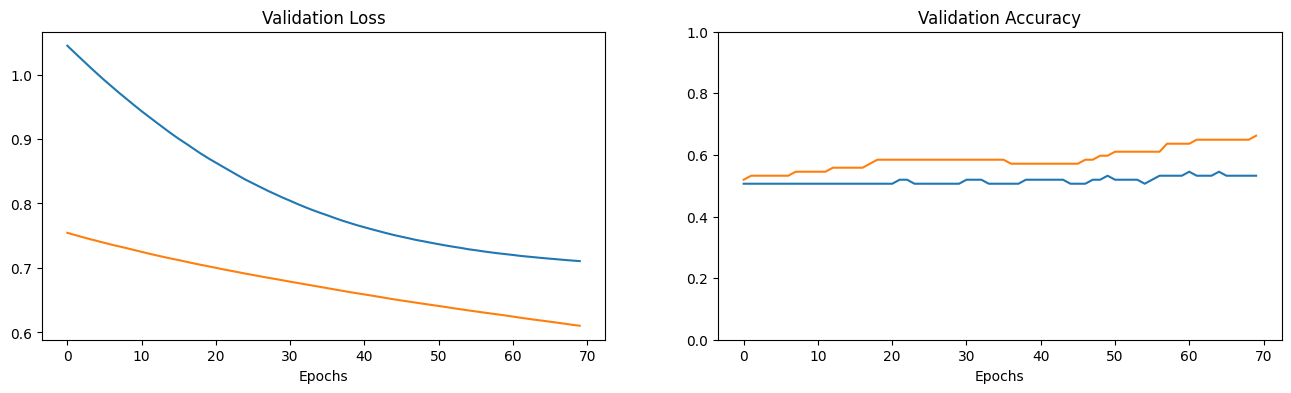

In [17]:
import matplotlib.pyplot as plt

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

augmented_data_val_loss = augmented_data_history.history['val_loss']
augmented_data_val_accuracy = augmented_data_history.history['val_accuracy']

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(val_loss)
ax.plot(augmented_data_val_loss)
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")

ax2 = fig.add_subplot(122)
ax2.plot(val_accuracy)
ax2.plot(augmented_data_val_accuracy)
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)

plt.show()